In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(lme4)
library(lmerTest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [3]:
setwd('/shared/3/projects/style-influence')

In [4]:
#df = fread('data/final_samples/formality_allmetrics.tsv', sep='\t')
df = fread('data/final_samples/formality_allmetrics_with_subreddits.tsv', sep='\t')
nrow(df)

[1] 16893013

## Clean Data

- Fix data types and remove a few aberrant values
- Outlier removal (threshold for extreme outliers = 10\*IQR)
- Standardize some columns (not the [0,1] variables)

In [4]:
remove_outlier <- function(x, thr=10){
    iqr = IQR(x, na.rm=T)
    lo = quantile(x, 0.25, na.rm=T) - thr*iqr
    hi = quantile(x, 0.75, na.rm=T) + thr*iqr
    x[x < lo] = lo
    x[x > hi] = hi
    x
}

In [5]:
nrow(df)
df <- df[controversiality %in% c('0','0.0','1','1.0'),]

[1] 16893013

In [9]:
nrow(df)
df <- df %>%
    mutate(num_parent_markers = scale(remove_outlier(num_parent_markers)),
           num_markers = scale(remove_outlier(num_markers)),
           parent_num_markers = scale(remove_outlier(parent_num_markers)),
           num_tokens = scale(remove_outlier(as.numeric(num_tokens))),
           parent_num_tokens = scale(remove_outlier(as.numeric(parent_num_tokens))),
           score = remove_outlier(as.numeric(score)),
           parent_score = remove_outlier(as.numeric(parent_score)),
           depth = remove_outlier(as.numeric(depth)),
           max_depth = remove_outlier(as.numeric(max_depth)),
           controversiality = as.integer(controversiality),
           parent_controversiality = as.integer(parent_controversiality),
           banned = ifelse(banned, 1, 0),
           wait_time = remove_outlier(created_utc - parent_created_utc)/60/24,
           tenure = remove_outlier(tenure)/60/60/24,
           subreddit_activity = remove_outlier(subreddit_activity),
           total_activity = remove_outlier(total_activity)
          )

[1] 16893013

In [10]:
re_min = 30

x = table(df$author)
summary(x >= re_min)

x = table(df$subreddit)
summary(x >= re_min)

df <- df %>%
    group_by(author) %>%
    mutate(author_re = ifelse(n() >= re_min, author, 'other')) %>%
    ungroup() %>%
    group_by(subreddit) %>%
    mutate(subreddit_re = ifelse(n() >= re_min, subreddit, 'other'))

table(df$author_re=='other')
table(df$subreddit_re=='other')

   Mode   FALSE    TRUE 
logical 2300196   74310 

   Mode   FALSE    TRUE 
logical   45069   23719 


   FALSE     TRUE 
 5605757 11287256 


   FALSE     TRUE 
16442929   450084 

In [11]:
fwrite(df, 'data/final_samples/final_regression_data.tsv', sep='\t', row.names=F)


## Get Random Seeds

Used for sampling in subsequent figures 

In [12]:
set.seed(2023)
seeds <- sample(1:2147483647, 1000, replace=F)
writeLines(as.character(seeds), 'data/random_seeds.csv')

## Basic Analysis

In [13]:
setDT(df)
class(df)

Warning message in setDT(df):
“Some columns are a multi-column type (such as a matrix column): [12, 18, 19, 20, 21]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column.”


[1] "data.table" "data.frame"

In [14]:
nrow(df) # number of comments

length(unique(df$author)) # number of unique authors overall
length(unique(df$author_re)) # number of unique authors in RE

length(unique(df$subreddit)) # number of unique subreddits overall
length(unique(df$subreddit_re)) # number of unique subreddits in RE


[1] 16893013

[1] 2374506

[1] 74311

[1] 68788

[1] 23720

Distribution of outcomes:

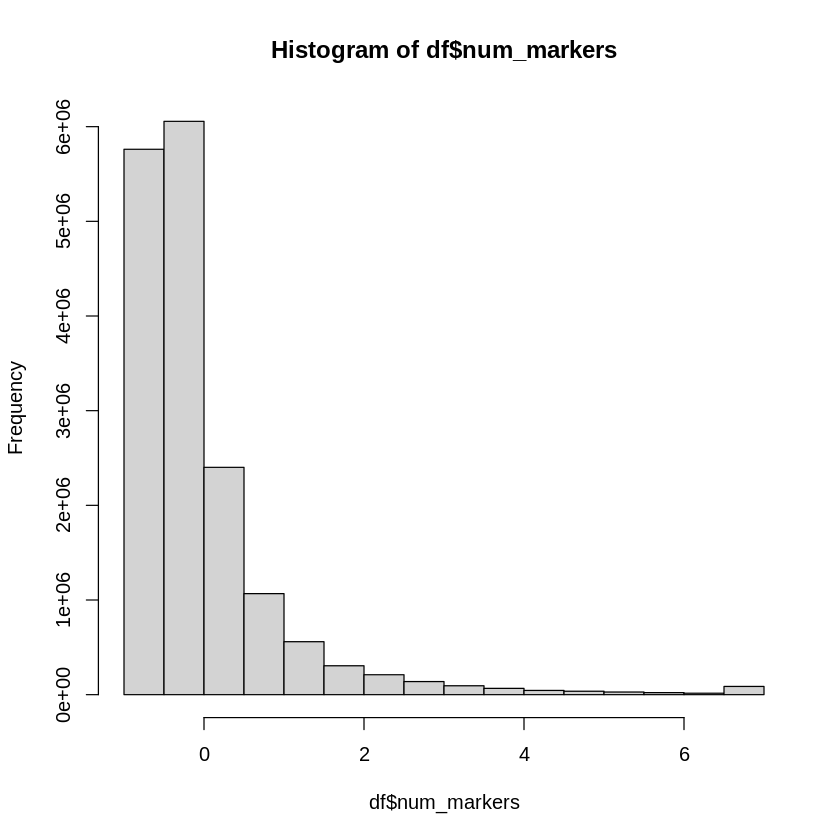

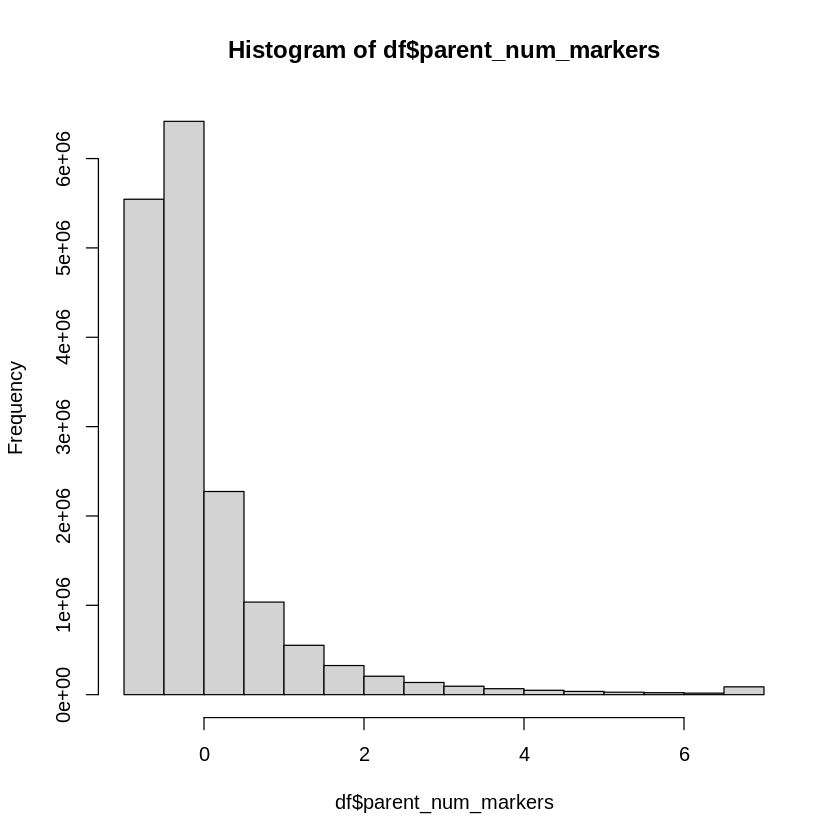

In [15]:
hist(df$num_markers)
hist(df$parent_num_markers)

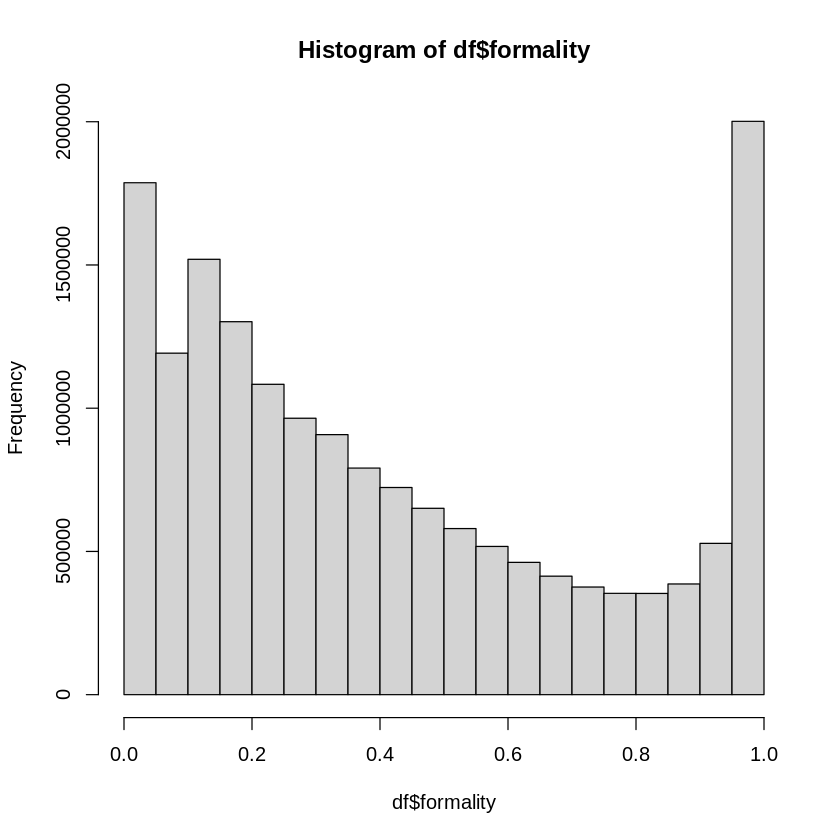

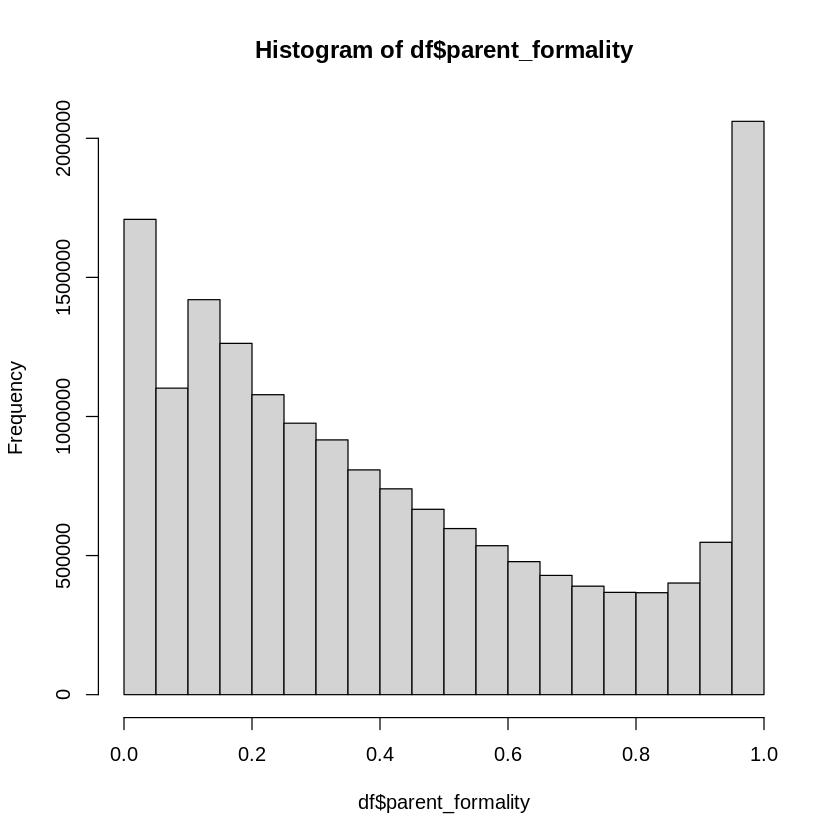

In [16]:
hist(df$formality)
hist(df$parent_formality)

Estimating LSM overall:

In [5]:
simple_mod_equation <- "style ~ parent_style + num_tokens + parent_num_tokens + depth"
mixed_mod_equation <- paste0(simple_mod_equation,
                             #" + (1 | author_re)",
                             " + (1 | subreddit_re)")

simple_mod_equation_cat <- gsub('parent_style','parent_style*category',simple_mod_equation)
mixed_mod_equation_cat <- gsub('parent_style','parent_style*category',mixed_mod_equation)

simple_mod_equation_cat2 <- gsub('parent_style','parent_style*category*category2',simple_mod_equation)
mixed_mod_equation_cat2 <- gsub('parent_style','parent_style*category*category2',mixed_mod_equation)

simple_mod_equation <- formula(simple_mod_equation)
mixed_mod_equation <- formula(mixed_mod_equation)
simple_mod_equation_cat <- formula(simple_mod_equation_cat)
mixed_mod_equation_cat <- formula(mixed_mod_equation_cat)
simple_mod_equation_cat2 <- formula(simple_mod_equation_cat2)
mixed_mod_equation_cat2 <- formula(mixed_mod_equation_cat2)


In [18]:
# function words style, basic regression
set.seed(seeds[1])
Sys.time()
df$style <- df$num_markers
df$parent_style <- df$parent_num_markers

Sys.time()
mod1 <- lm(simple_mod_equation, df %>% sample_n(1000000))
Sys.time()

summary(mod1)

[1] "2023-06-04 23:07:11 EDT"

[1] "2023-06-04 23:08:05 EDT"

[1] "2023-06-04 23:08:12 EDT"


Call:
lm(formula = simple_mod_equation, data = df %>% sample_n(1e+06))

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3397 -0.0454  0.0000  0.0510  3.2900 

Coefficients:
                    Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       -4.033e-04  2.086e-04   -1.934 0.053142 .  
parent_style       1.692e-01  9.452e-04  179.008  < 2e-16 ***
num_tokens         9.815e-01  1.769e-04 5548.370  < 2e-16 ***
parent_num_tokens -1.570e-01  9.444e-04 -166.251  < 2e-16 ***
depth              7.917e-05  2.173e-05    3.643 0.000269 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1528 on 999995 degrees of freedom
Multiple R-squared:  0.9766,	Adjusted R-squared:  0.9766 
F-statistic: 1.045e+07 on 4 and 999995 DF,  p-value: < 2.2e-16


In [19]:
# function words style, mixed effects
set.seed(seeds[2])
# Sys.time()
# df$style <- df$num_markers
# df$parent_style <- df$parent_num_markers

Sys.time()
mod2 <- lmer(mixed_mod_equation, df %>% sample_n(1000000))
Sys.time()

summary(mod2)

[1] "2023-06-04 23:08:13 EDT"

[1] "2023-06-04 23:10:09 EDT"

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mixed_mod_equation
   Data: df %>% sample_n(1e+06)

REML criterion at convergence: -978481.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-49.345  -0.320  -0.007   0.344  16.124 

Random effects:
 Groups       Name        Variance  Std.Dev.
 subreddit_re (Intercept) 0.0009077 0.03013 
 Residual                 0.0217485 0.14747 
Number of obs: 1000000, groups:  subreddit_re, 23042

Fixed effects:
                    Estimate Std. Error         df  t value Pr(>|t|)    
(Intercept)       -2.066e-03  3.783e-04  1.599e+04   -5.461  4.8e-08 ***
parent_style       1.451e-01  9.342e-04  9.306e+05  155.321  < 2e-16 ***
num_tokens         9.817e-01  1.757e-04  1.022e+06 5588.283  < 2e-16 ***
parent_num_tokens -1.348e-01  9.317e-04  9.314e+05 -144.671  < 2e-16 ***
depth              5.428e-05  2.328e-05  9.622e+05    2.331   0.0197 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.0

In [20]:
# formality style, basic regression
set.seed(seeds[3])
Sys.time()
df$style <- df$formality
df$parent_style <- df$parent_formality

Sys.time()
mod3 <- lm(simple_mod_equation, df %>% sample_n(1000000))
Sys.time()

summary(mod3)

[1] "2023-06-04 23:10:10 EDT"

[1] "2023-06-04 23:10:49 EDT"

[1] "2023-06-04 23:10:53 EDT"


Call:
lm(formula = simple_mod_equation, data = df %>% sample_n(1e+06))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8485 -0.2494 -0.0914  0.2276  0.7282 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        3.540e-01  6.069e-04  583.32   <2e-16 ***
parent_style       1.639e-01  9.857e-04  166.24   <2e-16 ***
num_tokens         4.489e-02  3.624e-04  123.87   <2e-16 ***
parent_num_tokens  1.701e-02  3.638e-04   46.75   <2e-16 ***
depth             -8.353e-04  4.468e-05  -18.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3128 on 997573 degrees of freedom
  (2422 observations deleted due to missingness)
Multiple R-squared:  0.06676,	Adjusted R-squared:  0.06675 
F-statistic: 1.784e+04 on 4 and 997573 DF,  p-value: < 2.2e-16


In [21]:
# formality style, mixed effects
set.seed(seeds[4])
# Sys.time()
# df$style <- df$formality
# df$parent_style <- df$parent_formality

Sys.time()
mod4 <- lmer(mixed_mod_equation, df %>% sample_n(1000000))
Sys.time()

summary(mod4)

[1] "2023-06-04 23:10:53 EDT"

[1] "2023-06-04 23:13:24 EDT"

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mixed_mod_equation
   Data: df %>% sample_n(1e+06)

REML criterion at convergence: 468539.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8199 -0.7704 -0.2732  0.6996  2.7626 

Random effects:
 Groups       Name        Variance Std.Dev.
 subreddit_re (Intercept) 0.006227 0.07891 
 Residual                 0.092186 0.30362 
Number of obs: 997510, groups:  subreddit_re, 23025

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        3.817e-01  9.785e-04  2.845e+04  390.04   <2e-16 ***
parent_style       1.066e-01  9.937e-04  1.003e+06  107.24   <2e-16 ***
num_tokens         3.471e-02  3.618e-04  1.008e+06   95.93   <2e-16 ***
parent_num_tokens  7.825e-03  3.635e-04  1.002e+06   21.53   <2e-16 ***
depth             -8.401e-04  4.816e-05  9.898e+05  -17.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

In [6]:
save(simple_mod_equation, mixed_mod_equation, 
     simple_mod_equation_cat, mixed_mod_equation_cat, 
     simple_mod_equation_cat2, mixed_mod_equation_cat2, 
     file = "reg_models.RData")
